# Generate Predictive Power Score (PPS)
Try to find best history size for each column in dataset

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import functools
from IPython.display import Image, clear_output

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from data_info import *
from preprocessing_helpers import *
from datetime import datetime
%matplotlib inline
pd.set_option("display.precision", 2)

In [2]:
new_iq_norm = [
                'precipitation_amt_mm',
                'reanalysis_air_temp_k',
                'reanalysis_avg_temp_k',
                'reanalysis_dew_point_temp_k',
                'reanalysis_max_air_temp_k',
                'reanalysis_min_air_temp_k',
                'reanalysis_precip_amt_kg_per_m2',
                'reanalysis_relative_humidity_percent',
                'reanalysis_sat_precip_amt_mm',
                'reanalysis_specific_humidity_g_per_kg',
                'reanalysis_tdtr_k',
                'station_avg_temp_c',
                'station_diur_temp_rng_c',
                'station_max_temp_c',
                'station_min_temp_c',
                'station_precip_mm',
]
new_iq_scale = [
                 'weekofyear',
]

extra_iq_cols = [
]
new_sj_norm = [
                'precipitation_amt_mm',
                'reanalysis_air_temp_k',
                'reanalysis_avg_temp_k',
                'reanalysis_dew_point_temp_k',
                'reanalysis_max_air_temp_k',
                'reanalysis_min_air_temp_k',
                'reanalysis_precip_amt_kg_per_m2',
                'reanalysis_relative_humidity_percent',
                'reanalysis_sat_precip_amt_mm',
                'reanalysis_specific_humidity_g_per_kg',
                'reanalysis_tdtr_k',
                'station_avg_temp_c',
                'station_diur_temp_rng_c',
                'station_max_temp_c',
                'station_min_temp_c',
                'station_precip_mm',
]
new_sj_scale = [
                 'weekofyear',
]

extra_sj_cols = [
]
new_iq_cols = [LABEL_COLUMN] + CATEGORICAL_COLUMNS + new_iq_norm + new_iq_scale + extra_iq_cols + [DATETIME_COLUMN]
new_iq_cols_no_label = CATEGORICAL_COLUMNS + new_iq_norm + new_iq_scale + extra_iq_cols + [DATETIME_COLUMN]
new_sj_cols = [LABEL_COLUMN] + CATEGORICAL_COLUMNS + new_sj_norm + new_sj_scale + extra_sj_cols + [DATETIME_COLUMN]
new_sj_cols_no_label = CATEGORICAL_COLUMNS + new_sj_norm + new_sj_scale + extra_sj_cols + [DATETIME_COLUMN]



In [3]:
from preprocessing_helpers import generate_lstm_data

sj_datasets, sj_norm_scale, sj_columns = generate_lstm_data(
    train_file, 
    single_step=True, 
    history_size=24, 
    cols=new_sj_cols, 
    norm_cols=new_sj_norm, 
    scale_cols=new_sj_scale,
    extra_columns=extra_sj_cols,
    prepend_with_file=train_file,
    train_frac=1.0,
    group_by_column=True
)
iq_datasets, iq_norm_scale, iq_columns = generate_lstm_data(
    train_file, 
    single_step=True, 
    history_size=32, 
    cols=new_iq_cols, 
    norm_cols=new_iq_norm, 
    scale_cols=new_iq_scale,
    extra_columns=extra_iq_cols,
    prepend_with_file=train_file,
    train_frac=1.0,
    group_by_column=True
)

In [4]:
sj_train_x, sj_train_y = sj_datasets[0]
iq_train_x, iq_train_y = iq_datasets[1]
print(len(sj_train_x[0]))
print(len(sj_train_y))
print(len(iq_train_x[0]))
print(len(iq_train_y))

17
936
17
520


In [5]:
train_x = np.array(sj_train_x)
train_y = np.array(sj_train_y)

## PSD for SJ city

Loop through all possible columns available for SJ city and compute PPS for each column for all history sizes from 3 to 51

In [6]:
columns = ['history_length'] + new_sj_norm+new_sj_scale
sj_score_df = pd.DataFrame(columns=columns)
for history_size in range(3,52):
    print(history_size)
    sj_datasets, sj_norm_scale, sj_columns = generate_lstm_data(
        train_file, 
        single_step=True, 
        history_size=history_size, 
        cols=new_sj_cols, 
        norm_cols=new_sj_norm, 
        scale_cols=new_sj_scale,
        extra_columns=extra_sj_cols,
        prepend_with_file=train_file,
        train_frac=1.0,
        group_by_column=True
    )
    sj_train_x, sj_train_y = sj_datasets[0]
    train_x = np.array(sj_train_x)
    train_y = np.array(sj_train_y)
    scores = []
    for col_idx, col_name in enumerate(sj_columns):
        col1_data = []
        for i in range(train_x.shape[0]):
            col1_data.append(train_x[i][col_idx])

        col1_data = np.array(col1_data)
        col1_data.shape
        regressor = DecisionTreeRegressor(random_state=0)
        score = cross_val_score(regressor, col1_data, train_y, cv=10, scoring='neg_mean_absolute_error')
        scores.append(score.mean())

    sj_score_df = sj_score_df.append(pd.Series([history_size] + scores, index=columns), ignore_index=True)

3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51


### Move history size to be an index and generate heatmap for MAE

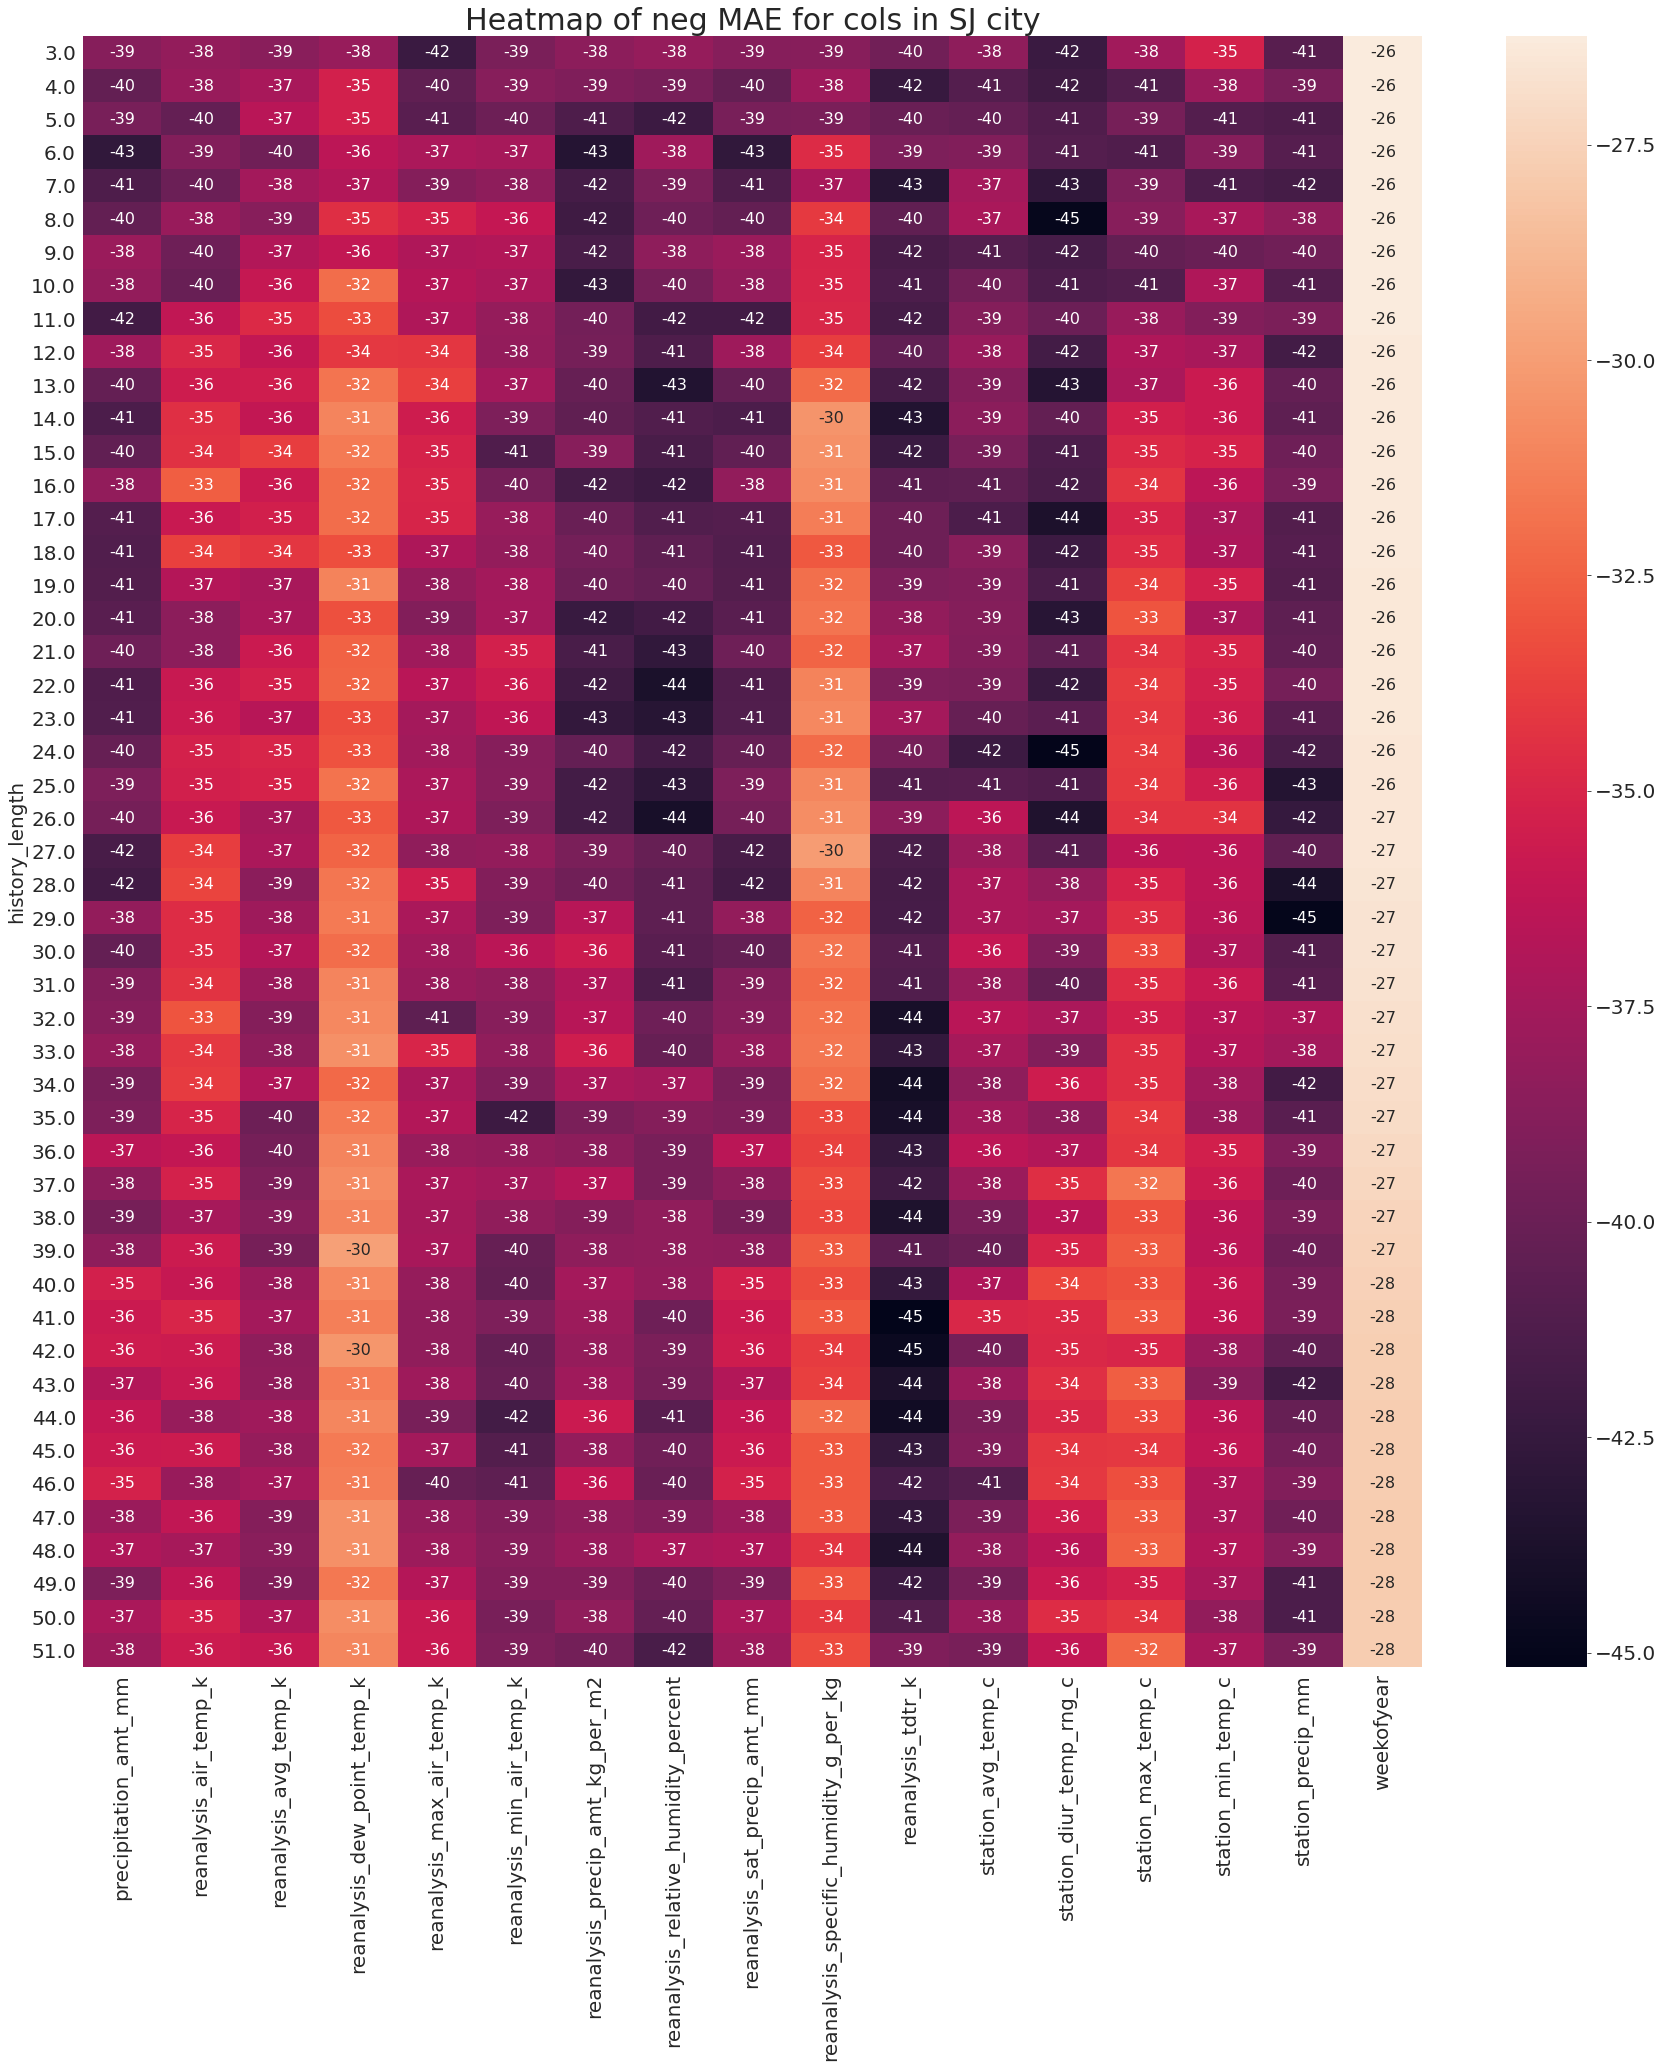

In [7]:
map_data = sj_score_df.copy()
map_data = map_data.set_index('history_length')

with sns.axes_style("white"):
    plt.rcParams['font.size'] = 20
    f, ax = plt.subplots(figsize=(30, 30))
    ax = sns.heatmap(map_data, annot=True,annot_kws={'size':16})
    plt.title('Heatmap of neg MAE for cols in SJ city', fontsize = 30)

## PSD for IQ city

Loop through all possible columns available for SJ city and compute PPS for each column for all history sizes from 3 to 51

In [8]:
columns = ['history_length'] + new_iq_norm+new_iq_scale
iq_score_df = pd.DataFrame(columns=columns)
for history_size in range(3,52):
    print(history_size)
    iq_datasets, iq_norm_scale, iq_columns = generate_lstm_data(
        train_file, 
        single_step=True, 
        history_size=history_size, 
        cols=new_iq_cols, 
        norm_cols=new_iq_norm, 
        scale_cols=new_iq_scale,
        extra_columns=extra_iq_cols,
        prepend_with_file=train_file,
        train_frac=1.0,
        group_by_column=True
    )
    iq_train_x, iq_train_y = iq_datasets[1]
    train_x = np.array(iq_train_x)
    train_y = np.array(iq_train_y)
    scores = []
    for col_idx, col_name in enumerate(iq_columns):
        col1_data = []
        for i in range(train_x.shape[0]):
            col1_data.append(train_x[i][col_idx])

        col1_data = np.array(col1_data)
        col1_data.shape
        regressor = DecisionTreeRegressor(random_state=0)
        score = cross_val_score(regressor, col1_data, train_y, cv=10, scoring='neg_mean_absolute_error')
        scores.append(score.mean())

    iq_score_df = iq_score_df.append(pd.Series([history_size] + scores, index=columns), ignore_index=True)

3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51


### Move history size to be an index and generate heatmap for MAE

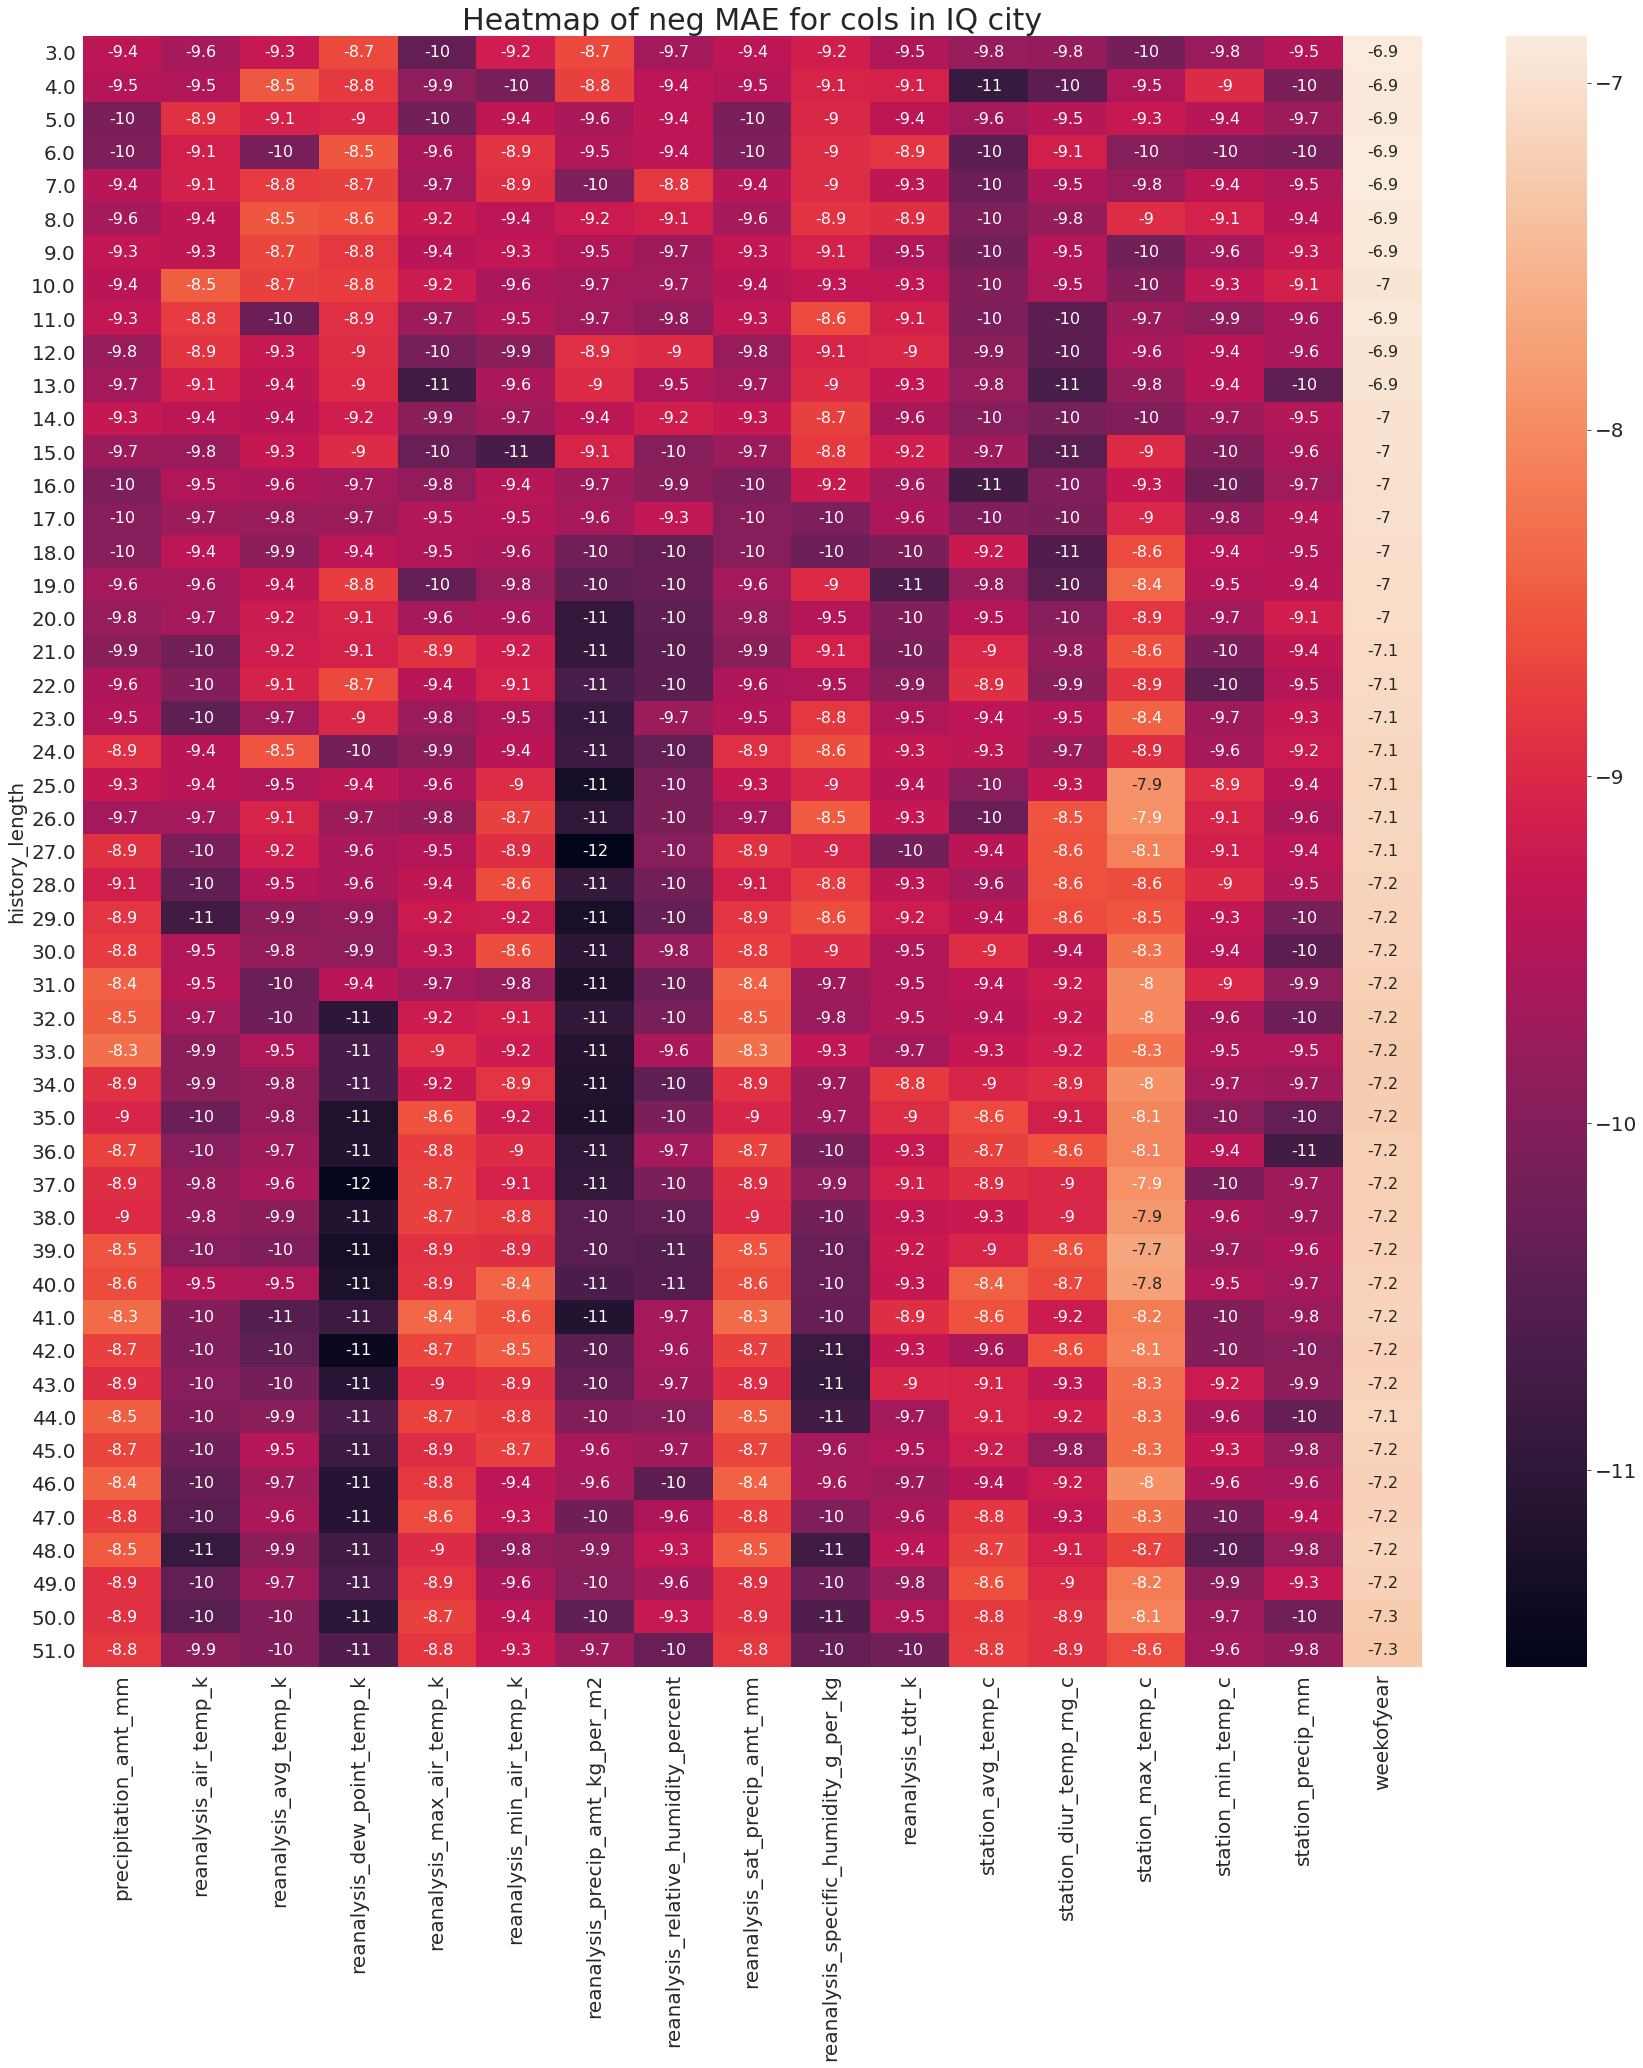

In [9]:
map_data = iq_score_df.copy()
map_data = map_data.set_index('history_length')

with sns.axes_style("white"):
    plt.rcParams['font.size'] = 20
    f, ax = plt.subplots(figsize=(30, 30))
    ax = sns.heatmap(map_data, annot=True,annot_kws={'size':16})
    plt.title('Heatmap of neg MAE for cols in IQ city', fontsize = 30)